<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Предобработка-текста" data-toc-modified-id="Предобработка-текста-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предобработка текста</a></span></li><li><span><a href="#Частотный-анализ" data-toc-modified-id="Частотный-анализ-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Частотный анализ</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span><ul class="toc-item"><li><span><a href="#Мешок-слов-и-N-граммы" data-toc-modified-id="Мешок-слов-и-N-граммы-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span><strong>Мешок слов и N-граммы</strong></a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span><strong>TF-IDF</strong></a></span></li><li><span><a href="#Word2vec" data-toc-modified-id="Word2vec-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span><strong>Word2vec</strong></a></span></li><li><span><a href="#BERT" data-toc-modified-id="BERT-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span><strong>BERT</strong></a></span></li></ul></li><li><span><a href="#RNN" data-toc-modified-id="RNN-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RNN</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:** Обучить модель классифицировать комментарии на позитивные и негативные нанаборе данных с разметкой о токсичности правок. 

**Метрика:** *F1* не меньше 0.75.

**Описание данных:**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
!pip install gensim --no-cache-dir --no-binary :all:
!pip install transformers
!pip install transformers datasets accelerate nvidia-ml-py3
!pip install catboost
!pip install dstoolbox
!pip install skorch

In [ ]:
import pandas as pd 
import re
import transformers as ppb 
import numpy as np
from scipy import stats
from pynvml import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score 
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from skorch import NeuralNetClassifier 
from skorch.callbacks import EpochScoring, EarlyStopping
import nltk 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords 
from wordcloud import WordCloud
from gensim.models import Word2Vec 
import gensim.downloader as api 
import matplotlib.pyplot as plt 
from dstoolbox.transformers import Padder2d
from dstoolbox.transformers import TextFeaturizer
from tqdm import notebook 
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Embedding, LSTM, Dense 
from tensorflow.keras.optimizers import Adam 
from catboost import CatBoostClassifier
import torch
from torch import nn
F = nn.functional
from warnings import simplefilter
simplefilter(action='ignore')

In [ ]:
# константы
VOCAB_SIZE = 20000
MAX_LEN = 5000 
USE_CUDA = torch.cuda.is_available()  
NUM_CV_STEPS = 5

Проверка корректной работы GPU:

In [ ]:
!nvidia-smi

In [ ]:
torch.cuda.is_available()

In [ ]:
tf.test.gpu_device_name()

In [ ]:
# считываем данные и создаём корпус для обучения
data = pd.read_csv('toxic_comments.csv', index_col=0, on_bad_lines="skip", engine='python')
corpus = data['text']

In [ ]:
# посмотрим на среднюю и максимальную длину комментария в корпусе
len_sents = []
for sentence in corpus:
    len_sents.append(len(sentence))
print(sum(len_sents)/len(len_sents))
print(max(len_sents))

In [ ]:
data.info()

В корпусе комментариев 159 292 записи. Прежде всего, нужно сделать предобработку текста: выполнить токенизацию и лемматизацию, очистить от лишних символов.

### Предобработка текста

In [ ]:
# функция для добавления частеречного тега в лемматизаторе
def get_wordnet_pos(word):

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# функция для предобработки текстов
def text_preprocessing(corpus):

    lemmatizer = WordNetLemmatizer() # инициализируем лемматизатор
    stop_words = stopwords.words('english') # задаём стоп-слова для очистки текстов от лишнего
    preprocessed = [] # создаём пустой список для записи обработанного текста
    for sentence in corpus:
    
        sentence = re.sub(r'[^a-zA-z]', ' ', sentence) # оставляем только латиницу
        sentence = list(lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)) # токенизация и лемматизация предложения
        sentence = " ".join(sentence) # возвращаем в строку
        preprocessed.append(sentence)

    return preprocessed

In [ ]:
corpus = text_preprocessing(corpus)

In [ ]:
corpus[:1]

### Частотный анализ

Далее выполним частотный анализ слов в корпусе текстов. Для этого нам понадобится объединить все тексты в один.

In [ ]:
#  функция для объединения корпуса
def listmerge(corpus):
    all=[]
    for lst in corpus:
        all.extend(lst)
    return all

In [ ]:
tokenized_corpus = []
for sent in corpus:
    tokenized_corpus.append(sent.split())

In [ ]:
merged_corpus = listmerge(tokenized_corpus) # объединяем корпус
merged_corpus = nltk.Text(merged_corpus) # преобразуем к классу Text
fdist = FreqDist(merged_corpus) # создаём экземпляр для частотного анализа

In [ ]:
# смотрим топ-15 самых часто встречаемых в корпусе текстов слов
fdist.most_common(15)

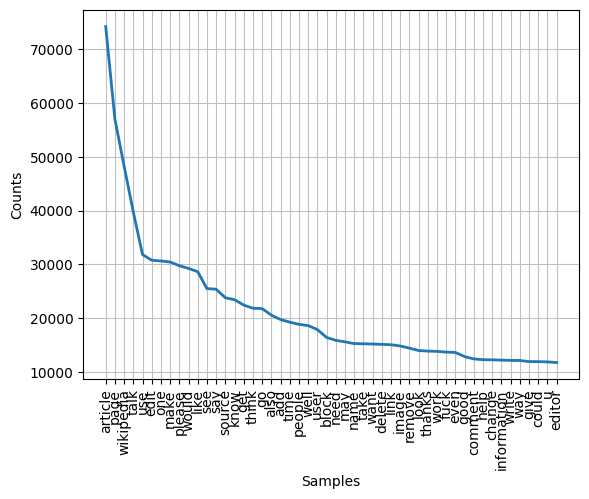

In [ ]:
# строим график частотности
fdist.plot(50,cumulative=False)

Среди наиболее часто употребляемых слов в корпусе нет коннотативно окрашенных слов. В основном, это нейтральные слова, относящиеся к информации в целом.

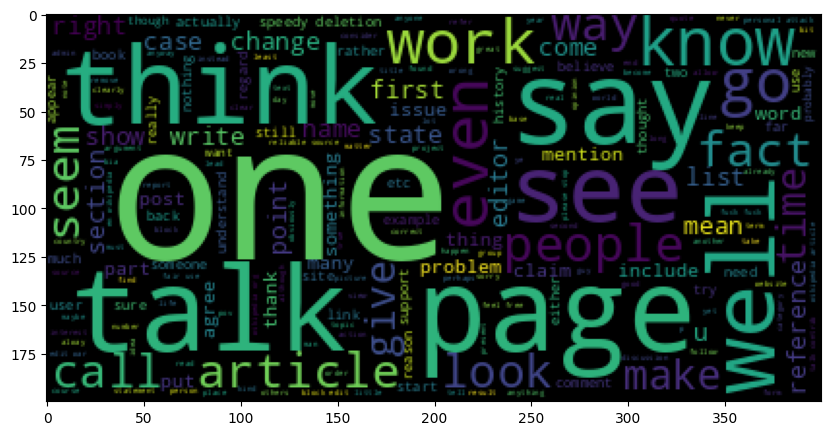

In [ ]:
# визуализируем облако слов
text_raw = " ".join(merged_corpus)
wordcloud = WordCloud().generate(text_raw)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.show()

### Вывод

Итак, в этом разделе мы произвели предобработку текста: лемматизацию и очистку от знаков препинания и символов, не являющихся латиницей. А также визуализировали облако слов и выяснили, что какого-то явного перевеса в сторону позитивных или негативных комментариев не наблюдается - слова в облаке нейтрального содержания.

## Обучение

Для подготовки признаков и обучения моделей нужно разделить выборку на обучающую и тестовую.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(corpus, data['toxic'], test_size=.2, random_state=42, stratify=data['toxic'])

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

### Логистическая регрессия

#### **Мешок слов и N-граммы**

Мешок слов - это модель, которая считает количество вхождений слова и формирует из этих чисел матрицу признаков.

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
params = {'model__C':[.01,.05,.1,.5,1,1.5,2],
          'model__penalty':['l1','l2'],
          'model__solver': ['lbfgs', 'liblinear', 'saga'],
          'vect__ngram_range': [(1,1), (2,2)]}

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_words)),
    ('model', LogisticRegression(random_state=42))])

bow_search = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='f1', verbose=0)

bow_search.fit(X_train, y_train)

In [ ]:
bow_search.best_score_

In [ ]:
bow_search.best_params_

#### **TF-IDF**

TF-IDF - это модель, которая совершает оценку важности каждого слова, основываясь на количестве упоминаний слова в отдельном тексте (TF) и частоте употребления слова во всём корпусе (IDF), и возвращает матрицу признаков.

In [ ]:
params = {'model__C':[.01,.05,.1,.5,1,1.5,2],
          'model__penalty':['l1','l2'],
          'model__solver': ['lbfgs', 'liblinear', 'saga'],
          'vect__ngram_range': [(1,1), (2,2)]}

pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stop_words)),
    ('model', LogisticRegression(random_state=42, max_iter=1000))])

tfidf_search = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='f1', verbose=0)

tfidf_search.fit(X_train, y_train)

In [ ]:
tfidf_search.best_score_

In [ ]:
tfidf_search.best_params_

#### **Word2vec**

Word2vec создаёт не просто векторы, а эмбеддинги - такие векторы, которые дополнительно учитывают контекст слов. Задача модели предсказать, являются ли заданные слова соседями.

In [ ]:
# обучаем модель на нашем корпусе текстов
w2v_model = Word2Vec(tokenized_corpus, window=10, min_count=2, sg=0) 

In [ ]:
# создаём функцию для векторизации признаков
def Word2Vectorizer(model, sentences):
    f = np.zeros((len(sentences), model.vector_size)) # инициализируем массив для вектора признаков
    for i,s in enumerate(sentences):
        for w in s:
            try:
                vec = model.wv[w]
            except KeyError:
                continue
            f[i,:] = f[i,:] + vec
            f[i,:] = f[i,:] / len(s)
    return f

In [ ]:
# получаем матрицы признаков на трейне и тесте
w2v_train = Word2Vectorizer(w2v_model, X_train)
w2v_test = Word2Vectorizer(w2v_model, X_test)

In [ ]:
lr = LogisticRegression(random_state=42, max_iter=1000)

params = {'C':[.01,.05,.1,.5,1,1.5,2],
          'penalty':['l1','l2'],
          'solver': ['lbfgs', 'liblinear', 'saga']}

w2v_search = RandomizedSearchCV(lr, params, cv=5, n_jobs=-1, scoring='f1', verbose=0)

w2v_search.fit(w2v_train, y_train)

In [ ]:
w2v_search.best_score_

#### **BERT**

BERT - это нейросеть для создания модели языка, которая учитывает контекст не только соседних слов, но и более дальних родственников, является эволюцией word2vec.

In [ ]:
# загрузим предобученную модель
model = ppb.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = ppb.AutoTokenizer.from_pretrained('unitary/toxic-bert')

Чтобы хватило оперативной памяти, эмбеддинги будем делать только для 2000 сэмплов на всём корпусе.

In [ ]:
bert_trunc, bert_vect, y_trunc, bert_y = train_test_split(data['text'], data['toxic'], random_state=42, test_size = 2000, stratify = data['toxic'])

In [ ]:
print(len(bert_vect))
print(len(bert_y))

In [ ]:
# выполняем токенизацию
tokenized = bert_vect.apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True)))

In [ ]:
# для векторов, длина которых меньше наибольшего вектора, добавляем отступы нулями
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
padded.shape

In [ ]:
# создаём маску для важных токенов
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape 

In [ ]:
batch_size = 100 # эмбеддинги BERT создаёт батчами
embeddings = []

for i in notebook.tqdm(range(len(padded)//batch_size)): # делаем цикл по батчам с отображением прогресса
    
    batch = torch.LongTensor(padded[batch_size*i : batch_size*(i+1)]) # преобразуем данные в тензоры
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i : batch_size*(i+1)])
    
    with torch.no_grad(): # для ускорения вычислений укажем, что градиенты не нужны
        batch_embeddings = model(batch, attention_mask=attention_mask_batch) # чтобы получить эмбеддинги для батча, передадим модели данные и маску
        
    embeddings.append(batch_embeddings[0][:, 0, :].numpy()) # из полученного тензора извлечём нужные элементы и добавим в список эмбеддингов
    
features = np.concatenate(embeddings) # соберём все эмбеддинги в матрицу признаков

Теперь полученные эмбеддинги нужно разделить на обучающую и тестовую выборки.

In [ ]:
bert_train, bert_test, bert_y_train, bert_y_test = train_test_split(features, bert_y, test_size=.1, random_state=42)

print(bert_train.shape)
print(bert_y_train.shape)
print(bert_test.shape)
print(bert_y_test.shape)

In [ ]:
lr = LogisticRegression(random_state=42, max_iter=1000)

params = {'C':[.01,.05,.1,.5,1,1.5,2],
          'penalty':['l1','l2'],
          'solver': ['lbfgs', 'liblinear', 'saga']}

bert_search = RandomizedSearchCV(lr, params, cv=5, n_jobs=-1, scoring='f1', verbose=0)

bert_search.fit(bert_train, bert_y_train)

In [ ]:
bert_search.best_score_

In [ ]:
bert_search.best_params_

In [ ]:
bert_model = bert_search.best_estimator_

### RNN

На вход нейросети нужно подать однородный массив целых чисел, в котором каждое число соответствует слову. Чтобы модель быстрее обучилась, возьмём лишь небольшую выборку.

In [ ]:
X, text_train, y, text_y_train = train_test_split(corpus, data['toxic'], test_size = 1000, random_state=42, stratify = data['toxic'])

print(len(text_train))
print(len(text_y_train))

In [ ]:
# пайплайн для трансформации текстов
steps = [
    ('to_idx', TextFeaturizer(max_features=VOCAB_SIZE)),
    ('pad', Padder2d(max_len=MAX_LEN, pad_value=0, dtype=int)),
]

In [ ]:
# построение простой RNN
class RNNClassifier(nn.Module):
    def __init__(
            self,
            embedding_dim=128,
            rec_layer_type='lstm',
            num_units=128,
            num_layers=2,
            dropout=0,
            bidirectional=False,
    ):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.rec_layer_type = rec_layer_type.lower()
        self.num_units = num_units
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.reset_weights()

    def reset_weights(self):
        self.emb = nn.Embedding(VOCAB_SIZE + 1, embedding_dim=self.embedding_dim)
        
        rec_layer = {'lstm': nn.LSTM, 'gru': nn.GRU}[self.rec_layer_type]

        self.rec = rec_layer(
            self.embedding_dim,
            self.num_units,
            num_layers=self.num_layers,
            dropout=self.dropout,
            bidirectional=self.bidirectional,
            batch_first=True,
        )

        self.drop = nn.Dropout(self.dropout)
        self.output = nn.Linear(self.num_units, 2)

    def forward(self, X):
        embeddings = self.emb(X)

        if self.rec_layer_type == 'gru':
            _, rec_out = self.rec(embeddings)
        else:
            _, (rec_out, _) = self.rec(embeddings)
        rec_out = rec_out[-1]  # take output of last RNN layer

        drop = self.drop(rec_out)
        out = F.softmax(self.output(drop), dim=-1)
        return out

In [ ]:
net = NeuralNetClassifier(
    RNNClassifier,
    device=('cuda' if USE_CUDA else 'cpu'),
    max_epochs=5,
    lr=0.01,
    optimizer=torch.optim.RMSprop,
)

In [ ]:
pipe = Pipeline(steps + [('net', net)])

In [ ]:
pipe.set_params(net__verbose=0, net__train_split=None)

In [ ]:
params = {
    'to_idx__ngram_range': [(1, 1), (2, 2)],
    'net__module__embedding_dim': stats.randint(32, 256 + 1),
    'net__module__rec_layer_type': ['gru', 'lstm'],
    'net__module__num_units': stats.randint(32, 256 + 1),
    'net__module__num_layers': [1, 2, 3],
    'net__module__dropout': stats.uniform(0, 0.9),
    'net__module__bidirectional': [True, False],
    'net__lr': [10**(-stats.uniform(1, 5).rvs()) for _ in range(NUM_CV_STEPS)],
    'net__max_epochs': [5, 10],
}

In [ ]:
rnn_search = RandomizedSearchCV(
    pipe, params, n_iter=5, verbose=0, refit=False, scoring='accuracy', cv=3)

In [ ]:
%time rnn_search.fit(text_train, text_y_train)

In [ ]:
rnn_search.best_score_, rnn_search.best_params_

### Catboost

In [ ]:
# базовая модель catboost
catb = CatBoostClassifier(random_state=42,  
                         iterations=100,
                         early_stopping_rounds=10,
                         learning_rate=0.1)

In [ ]:
%%time
params_catb = {
    'depth': [8, 9, 10],
    'min_data_in_leaf': [1, 2]
}

catb_search = RandomizedSearchCV(catb, params_catb, cv=5, n_jobs=-1, scoring='f1', verbose=0).fit(bert_train, bert_y_train, verbose=0) 

In [ ]:
catb_search.best_score_, best_params_

### Тестирование модели

Лучший результат на валидации показала модель логистической регрессии с BERT признаками. Значит, будем тестировать её.

In [ ]:
predictions = bert_model.predict(bert_test)
f1_score(bert_y_test, predictions)

Помимо этого, хотелось бы ещё протестировать модель логистической регрессии с TF-IDF признаками, которая дала второй по качеству результат.

In [ ]:
model = search.best_estimator_
predictions = model.predict(X_test)
f1_score(y_test, predictions)

## Выводы

В этом проекте мы использовали 3 модели:
- RNN
- логистическая регрессия
- CatBoost

и разные способы векторизации текстов:
- мешок слов и N-граммы
- TF-IDF
- word2vec
- BERT

Наилучший результат показала логистическая регрессия в сочетании с BERT эмбеддингами. Этот способ работает хорошо, потому что учитывает смысл слов, причём не только в ближайшем контексте, но и на большем расстоянии. Из всех способов векторизации текстов, применёных в этом проекте, этот - самый продвинутый и сложный. Однако, сложность алгоритма приводит к большим временным затратам.<br>

Порог метрики, заданный условием задачи, так же проходит логистическая регрессия с TF-IDF признаками. Это значит, что в данной задаче нет необходимости использовать сложные модели и эмбеддинги, т.к. признаки важности слов справляются достаточно хорошо и без усложнений и модель работает быстрее.

Причина может быть обусловлена спецификой задачи сентимент-анализа, в которой успех решения заключается в том, чтобы найти слова наиболее ярко характеризующие негативные и позитивные высказывания. TF-IDF векторизация как раз способна решить эту задачу.

Таким образом, если важна экономия времени, можно использовать логистическую регрессию на TF-IDF признаках. Если в приоритете качество модели - логистическую регрессию с BERT эмбеддингами.